In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as func

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


In [98]:
traindir = "/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/"
valdir = "/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/validation/"
testdir = "/content/drive/MyDrive/FA20_CS446_Project_Data/test_pub/"


In [99]:
class np_Dataset(torch.utils.data.Dataset):
    def __init__(self, np_file_paths, np_label_paths):
        self.files = np_file_paths
        self.label = np_label_paths
    
    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()

        y = np.load(self.label[index])
        y = torch.from_numpy(y).int()

        return x, y
    
    def __len__(self):
        return len(self.files)

class np_final_dataset(torch.utils.data.Dataset):
    def __init__(self, np_file_paths):
        self.files = np_file_paths
    
    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()

        return x
    
    def __len__(self):
        return len(self.files)

In [113]:
from os import walk

t_d = []
t_l = []
for (dirpath, dirnames, filenames) in walk(traindir):
    t_d = [(traindir + f) for f in filenames if f.endswith('imgs.npy')]
    t_d.sort()
    t_l = [traindir + f for f in filenames if f.endswith('seg.npy')]
    t_l.sort()
    break

v_d = []
v_l = []
for (dirpath, dirnames, filenames) in walk(valdir):
    v_d = [valdir + f for f in filenames if f.endswith('imgs.npy')]
    v_d.sort()
    v_l = [valdir + f for f in filenames if f.endswith('seg.npy')]
    v_l.sort()
    break
  
test = []

for (dirpath, dirnames, filenames) in walk(testdir):
  test = [testdir + f for f in filenames if f.endswith('imgs.npy')]
  test.sort()
  break

print(t_d+v_d)


['/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/001_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/002_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/003_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/004_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/005_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/006_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/007_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/008_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/009_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/010_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/011_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/012_imgs.npy', '/content/drive/MyDrive/FA20_CS446_Project_Data/data_pub/train/

In [117]:
train_data = torch.utils.data.DataLoader(np_Dataset(t_d+v_d, t_l+v_l), shuffle=True, num_workers=4, pin_memory=True)
val_data = torch.utils.data.DataLoader(np_final_dataset(test), num_workers=4, pin_memory=True)

In [7]:
#PyTorch

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = func.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [8]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))



class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = func.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weight[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]


In [9]:
def bbox3(img):
    """
    compute bounding box of the nonzero image pixels
    :param img: input image
    :return: bbox with shape (2,3) and contents [min,max]
    """
    rows = np.any(img, axis=1)
    rows = np.any(rows, axis=1)

    cols = np.any(img, axis=0)
    cols = np.any(cols, axis=1)

    slices = np.any(img, axis=0)
    slices = np.any(slices, axis=0)

    rows = np.where(rows)
    cols = np.where(cols)
    slices = np.where(slices)
    if (rows[0].shape[0] > 0):
        rmin, rmax = rows[0][[0, -1]]
        cmin, cmax = cols[0][[0, -1]]
        smin, smax = slices[0][[0, -1]]

        return np.array([[rmin, cmin, smin], [rmax, cmax, smax]])
    return np.array([[-1,-1,-1],[0,0,0]])

def get_bbox(data):
    bboxes = np.stack([bbox3(d) for d in data],axis=0)
    return np.stack([np.min(bboxes[:,0],axis=0),np.max(bboxes[:,1],axis=0)],axis=0)

In [115]:
min = np.array([0,0,0])
max = np.array([240, 240, 155])

count = 0
count2 = 0
crop_size = np.array([128, 128, 128])

def crop(t, l):
  t = t.numpy()[0]
  l = func.one_hot(l, num_classes=4)[0]
  l= l.permute(3, 0, 1, 2).numpy()
  # print(l.shape)
  _, w, h, d = l.shape
  if w < 128:
    left_w = (128-w)//2
    right_w = 128 - w - left_w
    t = np.pad(t, ((0, 0), (left_w, right_w), (0,0), (0,0)), mode='edge')
    l = np.pad(l, ((0,0), (left_w, right_w), (0,0), (0,0)), mode='edge')
  if h < 128:
    left_h = (128-h)//2
    right_h = 128-h-left_h
    t = np.pad(t, ((0, 0), (0,0), (left_h, right_h), (0,0)), mode='edge')
    l = np.pad(l, ( (0,0), (0,0), (left_h, right_h), (0,0)), mode='edge')
  if d < 128:
    left_d = (128-d)//2
    right_d = 128-d-left_d
    t = np.pad(t, ((0, 0), (0,0), (0,0), (left_d, right_d)), mode='edge')
    l = np.pad(l, ((0,0),  (0,0), (0,0), (left_d, right_d)), mode='edge')

  b = get_bbox(t)
  # print(t.shape)
  size = b[1] - b[0]
  # print(b, size)
  
  output = np.zeros(shape=(t.shape[0],)+tuple(crop_size))
  out_annotation = np.zeros(shape=output.shape)
  
  diff = np.array(crop_size) - np.array(size)
  low = diff // 2
  high = low - diff
  bbox = b - np.stack([low,high])

  index_input_min = bbox[0] #np.maximum(bbox[0],min)
  index_input_max = bbox[1] # np.minimum(bbox[1],max)
  
  size =  bbox[1] - bbox[0]

  # print(size)
  

  index_output_min = crop_size//2 - size//2 
  index_output_max = crop_size//2 + size - size//2

  # print(l.shape, out_annotation.shape, t.shape, index_input_min, index_input_max, index_output_min, index_output_max)
  
  output[:,index_output_min[0]:index_output_max[0],index_output_min[1]:index_output_max[1],index_output_min[2]:index_output_max[2]] =\
  t[:,index_input_min[0]:index_input_max[0],index_input_min[1]:index_input_max[1],index_input_min[2]:index_input_max[2]]
  
  out_annotation[:,index_output_min[0]:index_output_max[0],index_output_min[1]:index_output_max[1],index_output_min[2]:index_output_max[2]] =\
  l[:,index_input_min[0]:index_input_max[0],index_input_min[1]:index_input_max[1],index_input_min[2]:index_input_max[2]]

  return output, out_annotation, l.shape, (index_input_min, index_input_max)

In [152]:
import model
import loss
import weight_init


criterion = [loss.Dice_loss_joint(index=0,priority=1).cuda(), loss.BCE_Loss(index=0, bg_weight=1e-2).cuda()]
enc_layers = [1,2,2,4,4,4]
dec_layers = [1,1,1,1,1,1]
number_of_channels=[int(16*2**i) for i in range(1,1+len(enc_layers))]
number_of_channels[4] = number_of_channels[5] = 320
model = model.UNet(depth=len(enc_layers), encoder_layers=enc_layers, decoder_layers=dec_layers, number_of_channels=number_of_channels, number_of_outputs=4).float()
model.apply(weight_init.weight_init)



UNet [32, 64, 128, 256, 320, 320]


UNet(
  (encoder_convs): ModuleList(
    (0): Sequential(
      (0): Residual(
        (downsample): Sequential(
          (0): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
        )
        (conv1): conv(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): conv(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
        (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
      )
      (1): Residual(
        (conv1): conv(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): conv(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1

In [153]:
import metrics
import gc
import loss


model = nn.DataParallel(model).cuda()

optimizer = torch.optim.Adam(params=model.parameters(), **{"lr": 2e-5,"weight_decay": 1e-6,"amsgrad": True})

scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer, **{"step_size": 16000, "gamma": 0.5})

criterion = DiceLoss().cuda()
gc.collect()



9

In [73]:
from metrics import Metrics

class Dice(Metrics):
    def __init__(self, name='Dice', input_index=0,target_index=0, classes=4):
        super(Dice, self).__init__(name)
        self.input_index=input_index
        self.target_index=target_index
        self.classes = classes

    def update(self, ground, predict):
        pred = predict[self.input_index].detach()
        gr = ground[self.target_index].detach()

        assert (gr.shape == pred.shape)

        pred = (pred > 0.25)#torch.argmax(pred, dim=1).long().view(pred.size(0),-1)
        gr = (gr > 0.25)#torch.argmax(gr, dim=1).long().view(gr.size(0),-1)

        result = np.zeros(self.classes)

        for i in range(0, self.classes):
            p = pred[i].float().view(-1)#(pred == i).float()
            g = gr[i].float().view(-1)#(gr == i).float()

            numerator = (p * g).sum().cpu().numpy()
            denominator = (p + g).sum().cpu().numpy()

            r = 2 * numerator / denominator
            if np.isnan(r):
              r = 1

            result[i] = r

        self.accumulator = self.accumulator + np.mean(result)

        self.samples += 1

metric = Dice()

In [5]:
!cp -r /content/drive/MyDrive/FA20_CS446_Project_Data/data_pub /content/data_pub

^C


In [155]:
num_epochs = 50

for i in range(num_epochs):
  metric.reset()
  model.cuda()
  model.train()
  optimizer.zero_grad()
  count = 0
  for t, l in train_data:
    
    l =l.long()
    # print(l[l!=0])
    data, seg, og, _ = crop(t, l)


    
    data = torch.from_numpy(data[np.newaxis,:,:,:,:]).float().to(device)
    seg = torch.from_numpy(seg[np.newaxis,:,:,:,:]).float().to(device)


    ret = model(data)[0]

    # print(ret.shape, seg.shape)
    loss = criterion(ret, seg)

    loss.backward()

    if count % 2:
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()

    metric.update(seg, ret)
    print(count, metric.get())

    
    count += 1
    

  print("epoch {}: {}".format(i, metric.get()))
  
# print(count)
# print(count2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0 0.18494417323427115
1 0.18955285910563563
2 0.20805636164868813
3 0.2185704175845247
4 0.22455823182682075
5 0.23024924804579353
6 0.23239834881348403
7 0.23405145916442296
8 0.23521479679637253
9 0.23883854546277075
10 0.23937752266860376
11 0.2400263934747413
12 0.24002478167098779
13 0.24053683922568864
14 0.24077584225061904
15 0.24070509864437756
16 0.2423247298271947
17 0.24237145274954733
18 0.2426673262859648
19 0.2429265552998332
20 0.24316365959499886
21 0.2447298749923333
22 0.24480349786398006
23 0.24492444790447268
24 0.248003307887039
25 0.24963413461316514


Exception in thread Thread-84:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

In [76]:
class Dice_Val(Metrics):
    def __init__(self, name='Dice', input_index=0,target_index=0, classes=4):
        super(Dice_Val, self).__init__(name)
        self.input_index=input_index
        self.target_index=target_index
        self.classes = classes

    def update(self, ground, predict):
        pred = predict[self.input_index].detach().cpu().numpy()
        gr = ground[self.target_index].detach().cpu().numpy()

        assert (gr.shape == pred.shape)

        pred = np.where(pred > 0.25, 1.0, 0.0)#torch.argmax(pred, dim=1).long().view(pred.size(0),-1)
        # gr = (gr > 0.25)#torch.argmax(gr, dim=1).long().view(gr.size(0),-1)

        result = np.zeros(self.classes)

        for i in range(0, self.classes):
            # p = pred[i].float().view(-1)#(pred == i).float()
            # g = gr[i].float().view(-1)#(gr == i).float()

            numerator = np.sum(pred[i] * gr[i])
            denominator = np.sum(pred[i] + gr[i])

            r = 2 * numerator / denominator
            if np.isnan(r):
              r = 1

            result[i] = r

        self.accumulator = self.accumulator + np.mean(result)

        self.samples += 1

metric_val = Dice_Val()

NameError: ignored

In [129]:
min = np.array([0,0,0])
max = np.array([240, 240, 155])

count = 0
count2 = 0
crop_size = np.array([128, 128, 128])

def crop2(t):
  t = t.numpy()[0]
  # print(l.shape)
  _, w, h, d = t.shape
  if w < 128:
    left_w = (128-w)//2
    right_w = 128 - w - left_w
    t = np.pad(t, ((0, 0), (left_w, right_w), (0,0), (0,0)), mode='edge')
  if h < 128:
    left_h = (128-h)//2
    right_h = 128-h-left_h
    t = np.pad(t, ((0, 0), (0,0), (left_h, right_h), (0,0)), mode='edge')
  if d < 128:
    left_d = (128-d)//2
    right_d = 128-d-left_d
    t = np.pad(t, ((0, 0), (0,0), (0,0), (left_d, right_d)), mode='edge')

  b = get_bbox(t)
  # print(t.shape)
  size = b[1] - b[0]
  # print(b, size)
  
  output = np.zeros(shape=(t.shape[0],)+tuple(crop_size))
  
  diff = np.array(crop_size) - np.array(size)
  low = diff // 2
  high = low - diff
  bbox = b - np.stack([low,high])

  index_input_min = bbox[0] #np.maximum(bbox[0],min)
  index_input_max = bbox[1] # np.minimum(bbox[1],max)
  
  size =  bbox[1] - bbox[0]

  # print(size)
  

  index_output_min = crop_size//2 - size//2 
  index_output_max = crop_size//2 + size - size//2

  # print(l.shape, out_annotation.shape, t.shape, index_input_min, index_input_max, index_output_min, index_output_max)
  
  output[:,index_output_min[0]:index_output_max[0],index_output_min[1]:index_output_max[1],index_output_min[2]:index_output_max[2]] =\
  t[:,index_input_min[0]:index_input_max[0],index_input_min[1]:index_input_max[1],index_input_min[2]:index_input_max[2]]
  

  return output, (w, h, d), (index_input_min, index_input_max)


def crop_to_og(seg_ret, og, min_max):
  seg_ret = np.argmax(seg_ret, axis=0)

  # print(seg_ret.shape, og)

  w, h, d = og

  index_input_min, index_input_max = min_max

  if w > 128:
    left_w = (w-128)//2
    right_w = w - 128  - left_w
    seg_ret = np.pad(seg_ret, ( (left_w, right_w), (0,0), (0,0)), mode='edge')
  else:
    left_w = (128-w)//2
    right_w = 128 - w- left_w
    seg_ret = seg_ret[left_w:128-right_w, :, :]
  if h > 128:
    left_h = (h-128)//2
    right_h = h-128-left_h
    seg_ret = np.pad(seg_ret, (  (0,0), (left_h, right_h), (0,0)), mode='edge')
  else:
    left_h = (128-h)//2
    right_h = 128-h-left_h
    seg_ret = seg_ret[:,left_h:128-right_h, :]
  if d > 128:
    left_d = (d-128)//2
    right_d = d-128-left_d
    seg_ret = np.pad(seg_ret, ( (0,0), (0,0), (left_d, right_d)), mode='edge')
  else:
    left_d = (128-d)//2
    right_d = 128-d-left_d
    seg_ret = seg_ret[:,:, left_d:128-right_d]



  return seg_ret
  
  

In [142]:
!rm -r /content/output/

In [143]:
target_dir = "/content/output/{}_seg.npy"

for i, t in enumerate(val_data):
    data, og, max_min = crop2(t)

    data = torch.from_numpy(data[np.newaxis,:,:,:,:]).float().to(device)

    seg_ret = model(data)[0][0].detach().cpu().numpy()
    # print(seg_ret.shape)
    seg_ret = crop_to_og(seg_ret, og, max_min)
    # print(len(seg_ret[seg_ret==1]))
    np.save(target_dir.format(str(i+1).zfill(3)), seg_ret)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [145]:
!zip -r /content/output.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/001_seg.npy (deflated 100%)
  adding: content/output/028_seg.npy (deflated 100%)
  adding: content/output/016_seg.npy (deflated 100%)
  adding: content/output/068_seg.npy (deflated 100%)
  adding: content/output/066_seg.npy (deflated 100%)
  adding: content/output/005_seg.npy (deflated 100%)
  adding: content/output/038_seg.npy (deflated 100%)
  adding: content/output/021_seg.npy (deflated 100%)
  adding: content/output/045_seg.npy (deflated 100%)
  adding: content/output/048_seg.npy (deflated 100%)
  adding: content/output/035_seg.npy (deflated 100%)
  adding: content/output/018_seg.npy (deflated 100%)
  adding: content/output/052_seg.npy (deflated 100%)
  adding: content/output/051_seg.npy (deflated 100%)
  adding: content/output/046_seg.npy (deflated 100%)
  adding: content/output/042_seg.npy (deflated 100%)
  adding: content/output/025_seg.npy (deflated 100%)
  adding: content/output/030_seg.npy (deflated 100%)
  adding

(1, 4, 128, 128, 128)
(1, 4, 128, 128, 128)


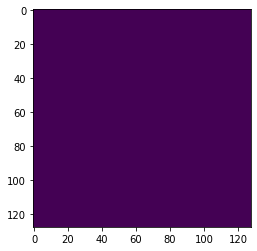

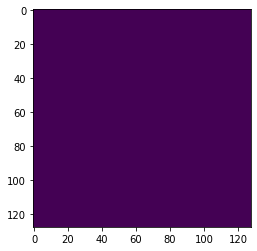

In [87]:
import matplotlib.pyplot as plt
 
# seg = seg.cpu().detach().numpy()
# check = check.cpu().detach().numpy()

print(seg.shape)
print(check.shape)
# new_loss = DiceLoss()
# print(check)
check = np.where(check > 0.25, 1.0, 0.0)
# print(check)
# print(new_loss(torch.from_numpy(check), torch.from_numpy(seg[np.newaxis,:,:,:,:])))

# for i in range(128):
  # print(np.sum(check[0,0,i]) - 128**2)

plt.imshow(check[0, 3, 70])
plt.figure()
plt.imshow(seg[0, 3, 70])

In [ ]:
sums = np.zeros(4)
cum_sum = 0
for t, l in train_data:
  l = l.long()[0]
  l = func.one_hot(l, num_classes=4).numpy()
  # print(l.shape)

  for i in range(4):
    v = np.sum(l[:, :, :, i])
    sums[i] += v
    cum_sum += v
  
  # print(sums, cum_sum)

In [15]:
weights = torch.from_numpy((sums/cum_sum)**-1).cuda()

print(weights)

tensor([  1.0325, 135.7554,  55.0987, 168.4151], device='cuda:0',
       dtype=torch.float64)
